In [8]:
import pandas as pd
import numpy as np

In [2]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pylab as pl

In [54]:
import fiona

In [118]:
from sklearn.cluster import KMeans

In [247]:
from sklearn.metrics import silhouette_score

## DOB permits

In [4]:
df_permits = pd.read_csv('C:/Users/shrey/Downloads/DOB_Permit_Issuance.csv')

C:\Users\shrey\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (1,8,9,10,15,31,33,36,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_permits.columns

Index(['BOROUGH', 'Bin #', 'House #', 'Street Name', 'Job #', 'Job doc. #',
       'Job Type', 'Self_Cert', 'Block', 'Lot', 'Community Board', 'Zip Code',
       'Bldg Type', 'Residential', 'Special District 1', 'Special District 2',
       'Work Type', 'Permit Status', 'Filing Status', 'Permit Type',
       'Permit Sequence #', 'Permit Subtype', 'Oil Gas', 'Site Fill',
       'Filing Date', 'Issuance Date', 'Expiration Date', 'Job Start Date',
       'Permittee's First Name', 'Permittee's Last Name',
       'Permittee's Business Name', 'Permittee's Phone #',
       'Permittee's License Type', 'Permittee's License #',
       'Act as Superintendent', 'Permittee's Other Title', 'HIC License',
       'Site Safety Mgr's First Name', 'Site Safety Mgr's Last Name',
       'Site Safety Mgr Business Name', 'Superintendent First & Last Name',
       'Superintendent Business Name', 'Owner's Business Type', 'Non-Profit',
       'Owner's Business Name', 'Owner's First Name', 'Owner's Last Name',
 

In [5]:
df_permits.head(3)

,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,Lot,...,Owner’s House State,Owner’s House Zip Code,Owner's Phone #,DOBRunDate,PERMIT_SI_NO,LATITUDE,LONGITUDE,COUNCIL_DISTRICT,CENSUS_TRACT,NTA_NAME
0,BROOKLYN,3326733,1070,EAST 104 STREET,301064023,1,A2,Y,8230,1,...,NY,11101,7184728000,11/03/2017 12:00:00 AM,1238812,40.644203,-73.892264,46.0,986.0,Canarsie
1,BROOKLYN,3322563,230,HANCOCK STREET,302036375,1,A1,Y,1838,43,...,NV,11225,NaN,11/03/2017 12:00:00 AM,2471045,40.682849,-73.947219,36.0,249.0,Bedford
2,MANHATTAN,1040756,504,PARK AVENUE,100209846,1,A3,NaN,1374,36,...,NY,10017,2127542310,11/03/2017 12:00:00 AM,191966,40.763075,-73.969695,4.0,11401.0,Upper East Side-Carnegie Hill


#### Considering relevant columns

In [5]:
df_permits_short = df_permits[['BOROUGH','Bldg Type','Zip Code','Permit Status','Issuance Date', 'Expiration Date','LATITUDE', 'LONGITUDE','CENSUS_TRACT']]

In [10]:
df_permits_short['Issuance Date'].unique()

array(['09/16/2002 12:00:00 AM', '12/28/2012 12:00:00 AM',
       '11/27/1991 12:00:00 AM', ..., '04/08/2018 12:00:00 AM',
       '04/14/2018 12:00:00 AM', '04/15/2018 12:00:00 AM'], dtype=object)

#### Creating a geodataframe

In [13]:
crs = {'init' :'epsg:4326'}

In [14]:
geometry = [Point(xy) for xy in zip(df_permits_short.LONGITUDE,df_permits_short.LATITUDE)]

In [15]:
df_permits_short_gdb = gpd.GeoDataFrame(df_permits_short, geometry=geometry, crs=crs)

In [22]:
df_permits_short_gdb.CENSUS_TRACT

numpy.float64

## Cenus Tract Shapefile

In [50]:
censustract = gpd.read_file('nyct2010wi.shp')

In [7]:
censustract.head(3)

,CTLabel,BoroCode,BoroName,CT2010,BoroCT2010,CDEligibil,NTACode,NTAName,PUMA,Shape_Leng,Shape_Area,geometry
0,9,5,Staten Island,000900,5000900,I,SI22,West New Brighton-New Brighton-St. George,3903,7729.016666,2.497010e+06,"POLYGON ((961685.0524291991 172726.407592773, ..."
1,98,1,Manhattan,009800,1009800,I,MN19,Turtle Bay-East Midtown,3808,5534.199988,1.906016e+06,"POLYGON ((993521.2968139651 213744.264038086, ..."
2,100,1,Manhattan,010000,1010000,I,MN19,Turtle Bay-East Midtown,3808,5692.168417,1.860938e+06,"POLYGON ((992351.1254272461 214645.420593262, ..."


In [17]:
censustract.CT2010 = pd.to_numeric(censustract.CT2010)

In [51]:
censustract = censustract.rename(columns={'CT2010':'CENSUS_TRACT'})

In [25]:
censustract.head(3)

,CTLabel,BoroCode,BoroName,CENSUS_TRACT,BoroCT2010,CDEligibil,NTACode,NTAName,PUMA,Shape_Leng,Shape_Area,geometry
0,9,5,Staten Island,900,5000900,I,SI22,West New Brighton-New Brighton-St. George,3903,7729.016666,2.497010e+06,"POLYGON ((961685.0524291991 172726.407592773, ..."
1,98,1,Manhattan,9800,1009800,I,MN19,Turtle Bay-East Midtown,3808,5534.199988,1.906016e+06,"POLYGON ((993521.2968139651 213744.264038086, ..."
2,100,1,Manhattan,10000,1010000,I,MN19,Turtle Bay-East Midtown,3808,5692.168417,1.860938e+06,"POLYGON ((992351.1254272461 214645.420593262, ..."


In [26]:
permits_shp = pd.merge(df_permits_short_gdb,censustract,on='CENSUS_TRACT' )

In [27]:
permits_shp.columns

Index(['BOROUGH', 'Bldg Type', 'Zip Code', 'Permit Status', 'Issuance Date',
       'Expiration Date', 'LATITUDE', 'LONGITUDE', 'CENSUS_TRACT',
       'geometry_x', 'CTLabel', 'BoroCode', 'BoroName', 'BoroCT2010',
       'CDEligibil', 'NTACode', 'NTAName', 'PUMA', 'Shape_Leng', 'Shape_Area',
       'geometry_y'],
      dtype='object')

## DOB Violations

In [4]:
dob_violation = pd.read_csv('DOB_Violations.csv')

C:\Users\shrey\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
dob_violation.columns

Index(['ISN_DOB_BIS_VIOL', 'BORO', 'BIN', 'BLOCK', 'LOT', 'ISSUE_DATE',
       'VIOLATION_TYPE_CODE', 'VIOLATION_NUMBER', 'HOUSE_NUMBER', 'STREET',
       'DISPOSITION_DATE', 'DISPOSITION_COMMENTS', 'DEVICE_NUMBER',
       'DESCRIPTION', 'ECB_NUMBER', 'NUMBER', 'VIOLATION_CATEGORY',
       'VIOLATION_TYPE'],
      dtype='object')

In [9]:
dob_violation['VIOLATION_TYPE'].value_counts()

E-ELEVATOR                                                       55187
AEUHAZ1-FAIL TO CERTIFY CLASS 1                                  27818
ACC1-(OTHER BLDGS TYPES) - ELEVATOR AFFIRMATION OF CORRECTION    27118
LBLVIO-LOW PRESSURE BOILER                                       16685
EVCAT1-ELEVATOR ANNUAL INSPECTION / TEST                         11866
C-CONSTRUCTION                                                    9397
BENCH-FAILURE TO BENCHMARK                                        6016
EVCAT5-NON-RESIDENTIAL ELEVATOR PERIODIC INSPECTION/TEST          3545
EARCX-FAILURE TO SUBMIT EER                                       2231
P-PLUMBING                                                        1641
LANDMK-LANDMARK                                                   1522
ACH1-(NYCHA) - ELEVATOR AFFIRMATION OF CORRECTION                 1428
JVIOS-PRIVATE RESIDENTIAL ELEVATOR                                1173
FISP-FACADE SAFETY PROGRAM                                        1146
HBLVIO

## 311 Data

In [32]:
df_311 = pd.read_csv('C:/Users/shrey/Downloads/311_Service_Requests_from_2010_to_Present (1).csv')

In [33]:
df_311.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Status', 'Due Date', 'Community Board', 'BBL', 'Borough',
       'Park Borough', 'Latitude', 'Longitude', 'Location'],
      dtype='object')

In [43]:
df_311_short = df_311[['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type','Borough','Latitude', 'Longitude','Location']]

In [35]:
df_311_short['Complaint Type'].value_counts()

Blocked Driveway                     244221
Illegal Parking                      180106
Dirty Conditions                     106178
Noise - Street/Sidewalk               98681
Sidewalk Condition                    79708
Missed Collection (All Materials)     69903
Noise - Vehicle                       53562
Derelict Vehicle                      49566
Sanitation Condition                  37211
Snow                                  19616
Other Enforcement                     19426
Traffic                               11658
Non-Emergency Police Matter           11316
Vending                               10865
Litter Basket / Request               10731
Curb Condition                         8827
Homeless Encampment                    4784
Overflowing Litter Baskets             4674
Noise Survey                           4457
Sweeping/Missed-Inadequate             4168
Recycling Enforcement                  3513
Public Payphone Complaint              2384
Animal Abuse                    

## Clustering 311 data

In [40]:
crs = {'init' :'epsg:4326'}

In [44]:
geometry = [Point(xy) for xy in zip(df_311_short.Longitude,df_311_short.Latitude)]

In [45]:
df_311_gdb = gpd.GeoDataFrame(df_311_short, geometry=geometry, crs=crs)

In [55]:
censustract = censustract.to_crs(epsg=4326)

In [57]:
df_311_with_censustract = gpd.sjoin(df_311_gdb,censustract, how='inner', op='within' )

C:\Users\shrey\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2831: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [59]:
df_311_with_censustract.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Borough', 'Latitude',
       'Longitude', 'Location', 'geometry', 'index_right', 'CTLabel',
       'BoroCode', 'BoroName', 'CENSUS_TRACT', 'BoroCT2010', 'CDEligibil',
       'NTACode', 'NTAName', 'PUMA', 'Shape_Leng', 'Shape_Area'],
      dtype='object')

In [179]:
df_311_with_censustract_short = df_311_with_censustract[['Complaint Type','CENSUS_TRACT']]

In [180]:
df_311_with_censustract_short['complaint'] = 1

C:\Users\shrey\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [181]:
df_311_groupby = df_311_with_censustract_short.groupby(['CENSUS_TRACT','Complaint Type']).sum().reset_index()

In [182]:
df_311_groupby.to_csv('df_311_groupby_complaint_type.csv')

In [183]:
ct = df_311_groupby.CENSUS_TRACT.unique()

#### Generating features for clustering

In [184]:
# Calculating vector of relative frequencies for each census tract
S_a = {}

for census_tract in ct:
    df_temp = df_311_groupby[df_311_groupby['CENSUS_TRACT'] == census_tract]
    s_area = np.sum(df_temp.complaint)      # total number of service requests in an area
    S_a[census_tract] = list(df_temp.complaint/s_area)

In [185]:
df_311_features = pd.DataFrame.from_dict(S_a, orient='index')

In [186]:
df_311_features = df_311_features.fillna(0)

#### Choosing number of clusters

In [248]:
range_n_clusters = range(2,10)

for n_clusters in range_n_clusters:
    km = KMeans(random_state=99,n_clusters=n_clusters)
    res=km.fit(df_311_features)
    cluster_labels = res.labels_
    silhouette_avg = silhouette_score(df_311_features, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.18090184806409865
For n_clusters = 3, the average silhouette_score is : 0.21897266919851108
For n_clusters = 4, the average silhouette_score is : 0.2152454138836062
For n_clusters = 5, the average silhouette_score is : 0.21076337667620512
For n_clusters = 6, the average silhouette_score is : 0.20895289007958728
For n_clusters = 7, the average silhouette_score is : 0.20411177867922908
For n_clusters = 8, the average silhouette_score is : 0.18387755698022573
For n_clusters = 9, the average silhouette_score is : 0.2089744673307027


[131.0019014477063, 108.4012869715199, 97.65266589472606, 92.35765659019205, 87.53121300443199, 83.94189363862816, 80.5192136345524, 77.50302829370764]


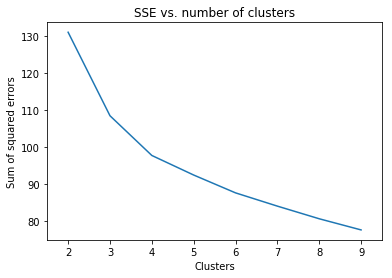

In [261]:
SSE = []
for i in range(2,10):
    km = KMeans(n_clusters = i)
    res=km.fit(df_311_features)
    SSE.append(res.inertia_)
print(SSE)

plt.gca()
plt.plot(range(2,10),SSE)
plt.xlabel("Clusters")
plt.ylabel("Sum of squared errors")
plt.title("SSE vs. number of clusters")
plt.xlim(1.5,9.5)
plt.show()

In [254]:
km = KMeans(random_state=99,n_clusters=5)
res=km.fit(df_311_features)

In [255]:
df_311_clusters = pd.DataFrame(df_311_features.reset_index()['index'])

In [256]:
df_311_clusters['cluster'] = res.labels_

In [257]:
df_311_clusters.rename(columns={'index':'CENSUS_TRACT'}, inplace=True)

In [211]:
censustract.merge(df_311_clusters, on='CENSUS_TRACT',how='left')

,CTLabel,BoroCode,BoroName,CENSUS_TRACT,BoroCT2010,CDEligibil,NTACode,NTAName,PUMA,Shape_Leng,Shape_Area,geometry,cluster
0,9,5,Staten Island,000900,5000900,I,SI22,West New Brighton-New Brighton-St. George,3903,7729.016666,2.497010e+06,POLYGON ((-74.08130714211008 40.64074191709274...,2.0
1,98,1,Manhattan,009800,1009800,I,MN19,Turtle Bay-East Midtown,3808,5534.199988,1.906016e+06,POLYGON ((-73.96653673334281 40.75335025612635...,2.0
2,100,1,Manhattan,010000,1010000,I,MN19,Turtle Bay-East Midtown,3808,5692.168417,1.860938e+06,POLYGON ((-73.97075919418829 40.75582485124249...,2.0
3,102,1,Manhattan,010200,1010200,I,MN17,Midtown-Midtown South,3807,5687.802440,1.860993e+06,"POLYGON ((-73.97398183196347 40.7571797580858,...",0.0
4,104,1,Manhattan,010400,1010400,I,MN17,Midtown-Midtown South,3807,5693.035870,1.864600e+06,POLYGON ((-73.97720026523596 40.75853793354626...,2.0
5,113,1,Manhattan,011300,1011300,I,MN17,Midtown-Midtown South,3807,5699.860888,1.890907e+06,POLYGON ((-73.98548819085713 40.75293517965362...,2.0
6,114.02,1,Manhattan,011402,1011402,I,MN40,Upper East Side-Carnegie Hill,3805,4125.256348,1.063547e+06,POLYGON ((-73.96612747295728 40.76217929969562...,2.0
7,130,1,Manhattan,013000,1013000,I,MN40,Upper East Side-Carnegie Hill,3805,5807.973028,1.918145e+06,POLYGON ((-73.96431940640112 40.77042295736221...,2.0
8,140,1,Manhattan,014000,1014000,I,MN40,Upper East Side-Carnegie Hill,3805,5820.815890,1.925984e+06,POLYGON ((-73.95779380470225 40.77359989745678...,2.0
9,148.01,1,Manhattan,014801,1014801,I,MN40,Upper East Side-Carnegie Hill,3805,3135.951423,5.592162e+05,POLYGON ((-73.95448224114996 40.77813866451909...,2.0


C:\Users\shrey\Anaconda3\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


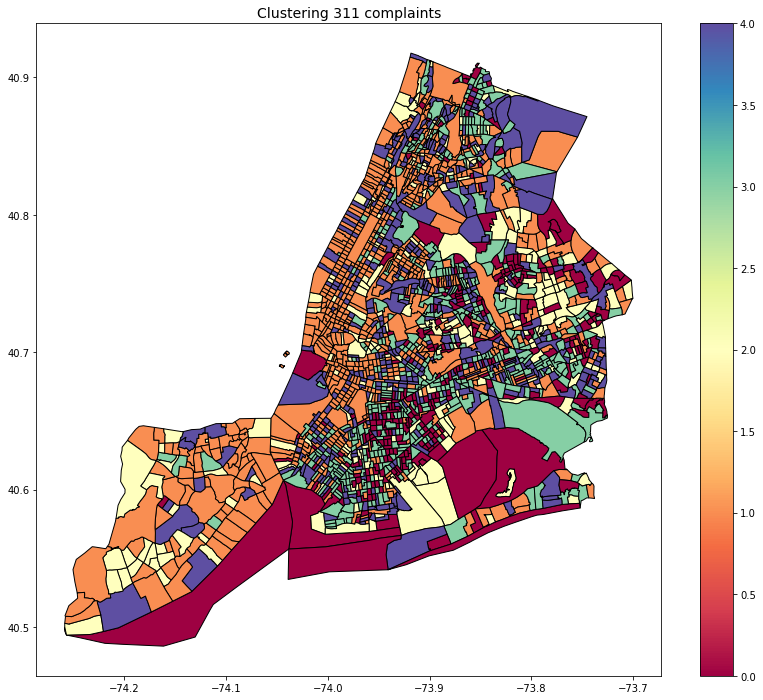

In [263]:
f, ax = pl.subplots(figsize=(14,12))
#censustractSHAPE.plot(ax=ax, color='white')
pl.title('Clustering 311 complaints', fontsize=14)
censustract.merge(df_311_clusters, on='CENSUS_TRACT',how='left').plot(ax=ax, cmap='Spectral',legend=True,column='cluster',edgecolor='black')
pl.savefig('Clustering_311.png')

In [ ]:
nypd_df = pd.read_csv('C:/Users/shrey/Downloads/NYPD_Complaint_Data_Historic.csv')

In [12]:
nypd_df.head(3)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,101109527,12/31/2015,23:45:00,NaN,NaN,12/31/2015,113,FORGERY,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,44.0,INSIDE,BAR/NIGHT CLUB,NaN,NaN,1007314.0,241257.0,40.828848,-73.916661,"(40.828848333, -73.916661142)"
1,153401121,12/31/2015,23:36:00,NaN,NaN,12/31/2015,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,...,103.0,OUTSIDE,NaN,NaN,NaN,1043991.0,193406.0,40.697338,-73.784557,"(40.697338138, -73.784556739)"
2,569369778,12/31/2015,23:30:00,NaN,NaN,12/31/2015,117,DANGEROUS DRUGS,503.0,"CONTROLLED SUBSTANCE,INTENT TO",...,28.0,NaN,OTHER,NaN,NaN,999463.0,231690.0,40.802607,-73.945052,"(40.802606608, -73.945051911)"


In [14]:
nypd_df.columns

Index(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD', 'PD_DESC',
       'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'JURIS_DESC', 'BORO_NM',
       'ADDR_PCT_CD', 'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'PARKS_NM',
       'HADEVELOPT', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude',
       'Lat_Lon'],
      dtype='object')

In [15]:
nypd_df['OFNS_DESC'].value_counts()

PETIT LARCENY                           903753
HARRASSMENT 2                           670000
ASSAULT 3 & RELATED OFFENSES            574040
CRIMINAL MISCHIEF & RELATED OF          554633
GRAND LARCENY                           473457
DANGEROUS DRUGS                         371118
OFF. AGNST PUB ORD SENSBLTY &           305829
ROBBERY                                 214271
FELONY ASSAULT                          204904
BURGLARY                                204396
DANGEROUS WEAPONS                       134706
MISCELLANEOUS PENAL LAW                 132606
OFFENSES AGAINST PUBLIC ADMINI          109053
GRAND LARCENY OF MOTOR VEHICLE          108387
INTOXICATED & IMPAIRED DRIVING           79695
CRIMINAL TRESPASS                        70472
VEHICLE AND TRAFFIC LAWS                 65717
THEFT-FRAUD                              61557
SEX CRIMES                               61240
FORGERY                                  55585
FRAUDS                                   35450
POSSESSION OF

In [21]:
nypd_df_robbery = nypd_df[nypd_df['OFNS_DESC'] == 'ROBBERY']

In [30]:
nypd_df_robbery[nypd_df_robbery['PREM_TYP_DESC'] == 'STREET']['PD_DESC'].value_counts()

ROBBERY,OPEN AREA UNCLASSIFIED         82046
ROBBERY,PERSONAL ELECTRONIC DEVICE     18865
ROBBERY,POCKETBOOK/CARRIED BAG          6772
ROBBERY,NECKCHAIN/JEWELRY               3852
ROBBERY,CAR JACKING                     1609
ROBBERY,BICYCLE                         1186
ROBBERY,UNLICENSED FOR HIRE VEHICLE     1038
ROBBERY,PUBLIC PLACE INSIDE             1011
ROBBERY,LICENSED MEDALLION CAB           907
ROBBERY,RESIDENTIAL COMMON AREA          812
ROBBERY,COMMERCIAL UNCLASSIFIED          492
ROBBERY,DWELLING                         350
ROBBERY,BANK                             330
ROBBERY,HOME INVASION                    216
ROBBERY,DELIVERY PERSON                  161
ROBBERY,OF TRUCK DRIVER                  152
ROBBERY,LICENSED FOR HIRE VEHICLE        141
ROBBERY, PAYROLL                         136
ROBBERY,ATM LOCATION                     127
ROBBERY,CLOTHING                         103
ROBBERY,ON BUS/ OR BUS DRIVER             76
ROBBERY,BODEGA/CONVENIENCE STORE          49
ROBBERY, C

In [31]:
nypd_df.shape

(5580035, 24)